# Statistical arbitrage with Cointegration

## Pairs Trading & Statistical Arbitrage

Statistical arbitrage refers to strategies that employ some statistical model or method to take
advantage of what appears to be relative mispricing of assets, while maintaining a level of
market neutrality.

Pairs trading is a conceptually straightforward strategy that has been employed by algorithmic traders since at least the mid-eighties ([Gatev, Goetzmann, and Rouwenhorst 2006](http://www-stat.wharton.upenn.edu/~steele/Courses/434/434Context/PairsTrading/PairsTradingGGR.pdf)). The goal is to find two assets whose prices have historically moved together, track the spread (the difference between their prices), and, once the spread widens, buy the
loser that has dropped below the common trend and short the winner. If the relationship persists, the long and/or the short leg will deliver profits as prices converge and the positions are closed.

This approach extends to a multivariate context by forming baskets from multiple securities and trading one asset against a basket of two baskets against each other.

## Pairs Trading in Practice

In practice, the strategy requires two steps:

1. **Formation phase**: Identify securities that have a long-term mean-reverting relationship. Ideally, the spread should have a high variance to allow for frequent profitable trades while reliably reverting to the common trend.
2. **Trading phase**: Trigger entry and exit trading rules as price movements cause thespread to diverge and converge.

Several approaches to the formation and trading phases have emerged from increasingly active research in this area, across multiple asset classes, over the last several years. The book outlines the key differences between them; the notebook dives into an example application.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import Counter

from time import time
from pathlib import Path

import numpy as np
import pandas as pd

from pykalman import KalmanFilter
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
idx = pd.IndexSlice
sns.set_style('whitegrid')

In [5]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

### Johansen Test Critical Values

In [6]:
critical_values = {0: {.9: 13.4294, .95: 15.4943, .99: 19.9349},
                   1: {.9: 2.7055, .95: 3.8415, .99: 6.6349}}

In [7]:
trace0_cv = critical_values[0][.95] # critical value for 0 cointegration relationships
trace1_cv = critical_values[1][.95] # critical value for 1 cointegration relationship

## Load Data

In [39]:
DATA_PATH = Path('..', 'data') 
STORE = DATA_PATH / 'assets.h5'

### Get backtest prices

Combine OHLCV prices for relevant stock and ETF tickers.

In [57]:
def get_backtest_prices():
    with pd.HDFStore('data.h5') as store:
        tickers = store['tickers']

    with pd.HDFStore(STORE) as store:
        prices = (pd.concat([
            store['stooq/us/nyse/stocks/prices'],
            store['stooq/us/nyse/etfs/prices'],
            store['stooq/us/nasdaq/etfs/prices'],
            store['stooq/us/nasdaq/stocks/prices']])
                  .sort_index()
                  .loc[idx[tickers.index, '2016':'2019'], :])
    print(prices.info(null_counts=True))
    prices.to_hdf('backtest.h5', 'prices')
    tickers.to_hdf('backtest.h5', 'tickers')

In [58]:
get_backtest_prices()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 312863 entries, ('AA.US', Timestamp('2016-01-04 00:00:00')) to ('YUM.US', Timestamp('2019-12-31 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    312863 non-null  float64
 1   high    312863 non-null  float64
 2   low     312863 non-null  float64
 3   close   312863 non-null  float64
 4   volume  312863 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 13.2+ MB
None


### Load Stock Prices

In [11]:
# see notebook 05_cointagration_tests
stocks = pd.read_hdf('data.h5', 'stocks/close').loc['2015':]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-01-02 to 2019-12-31
Columns: 172 entries, AA.US to YUM.US
dtypes: float64(172)
memory usage: 1.7 MB


### Load ETF Data

In [12]:
# see notebook 05_cointagration_tests
etfs = pd.read_hdf('data.h5', 'etfs/close').loc['2015':]
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-01-02 to 2019-12-31
Columns: 139 entries, AAXJ.US to YCS.US
dtypes: float64(139)
memory usage: 1.3 MB


### Load Ticker Dictionary

In [13]:
names = pd.read_hdf('data.h5', 'tickers').to_dict()

In [14]:
pd.Series(names).count()

311

## Precompute Cointegration

In [15]:
def test_cointegration(etfs, stocks, test_end, lookback=2):
    start = time()
    results = []
    test_start = test_end - pd.DateOffset(years=lookback) + pd.DateOffset(days=1)
    etf_tickers = etfs.columns.tolist()
    etf_data = etfs.loc[str(test_start):str(test_end)]

    stock_tickers = stocks.columns.tolist()
    stock_data = stocks.loc[str(test_start):str(test_end)]
    n = len(etf_tickers) * len(stock_tickers)
    j = 0
    for i, s1 in enumerate(etf_tickers, 1):
        for s2 in stock_tickers:
            j += 1
            if j % 1000 == 0:
                print(f'\t{j:5,.0f} ({j/n:3.1%}) | {time() - start:.2f}')
            df = etf_data.loc[:, [s1]].dropna().join(stock_data.loc[:, [s2]].dropna(), how='inner')
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                var = VAR(df)
                lags = var.select_order()
                result = [test_end, s1, s2]
                order = lags.selected_orders['aic']
                result += [coint(df[s1], df[s2], trend='c')[1], coint(df[s2], df[s1], trend='c')[1]]

            cj = coint_johansen(df, det_order=0, k_ar_diff=order)
            result += (list(cj.lr1) + list(cj.lr2) + list(cj.evec[:, cj.ind[0]]))
            results.append(result)
    return results

### Define Test Periods

In [16]:
dates = stocks.loc['2016-12':'2019-6'].resample('Q').last().index
dates

DatetimeIndex(['2016-12-31', '2017-03-31', '2017-06-30', '2017-09-30',
               '2017-12-31', '2018-03-31', '2018-06-30', '2018-09-30',
               '2018-12-31', '2019-03-31', '2019-06-30'],
              dtype='datetime64[ns]', name='date', freq='Q-DEC')

### Run Tests

In [17]:
test_results = []
columns = ['test_end', 's1', 's2', 'eg1', 'eg2',
           'trace0', 'trace1', 'eig0', 'eig1', 'w1', 'w2']

for test_end in dates:
    print(test_end)
    result = test_cointegration(etfs, stocks, test_end=test_end)
    test_results.append(pd.DataFrame(result, columns=columns))

pd.concat(test_results).to_hdf('backtest.h5', 'cointegration_test')

2016-12-31 00:00:00
	1,000 (4.2%) | 54.32
	2,000 (8.4%) | 105.25
	3,000 (12.5%) | 156.85
	4,000 (16.7%) | 208.33
	5,000 (20.9%) | 259.67
	6,000 (25.1%) | 310.20
	7,000 (29.3%) | 361.73
	8,000 (33.5%) | 415.96
	9,000 (37.6%) | 467.39
	10,000 (41.8%) | 519.14
	11,000 (46.0%) | 571.14
	12,000 (50.2%) | 623.57
	13,000 (54.4%) | 679.03
	14,000 (58.6%) | 731.01
	15,000 (62.7%) | 786.51
	16,000 (66.9%) | 838.69
	17,000 (71.1%) | 891.46
	18,000 (75.3%) | 947.83
	19,000 (79.5%) | 999.86
	20,000 (83.7%) | 1051.32
	21,000 (87.8%) | 1102.79
	22,000 (92.0%) | 1155.83
	23,000 (96.2%) | 1210.67
2017-03-31 00:00:00
	1,000 (4.2%) | 51.45
	2,000 (8.4%) | 103.60
	3,000 (12.5%) | 154.91
	4,000 (16.7%) | 207.16
	5,000 (20.9%) | 259.57
	6,000 (25.1%) | 313.52
	7,000 (29.3%) | 367.18
	8,000 (33.5%) | 419.41
	9,000 (37.6%) | 472.77
	10,000 (41.8%) | 524.24
	11,000 (46.0%) | 576.73
	12,000 (50.2%) | 628.75
	13,000 (54.4%) | 680.14
	14,000 (58.6%) | 732.15
	15,000 (62.7%) | 788.75
	16,000 (66.9%) | 839.75
	17,0

#### Reload  Test Results

In [18]:
test_results = pd.read_hdf('backtest.h5', 'cointegration_test')
test_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262988 entries, 0 to 23907
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   test_end  262988 non-null  datetime64[ns]
 1   s1        262988 non-null  object        
 2   s2        262988 non-null  object        
 3   eg1       262988 non-null  float64       
 4   eg2       262988 non-null  float64       
 5   trace0    262988 non-null  float64       
 6   trace1    262988 non-null  float64       
 7   eig0      262988 non-null  float64       
 8   eig1      262988 non-null  float64       
 9   w1        262988 non-null  float64       
 10  w2        262988 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 24.1+ MB


## Identify Cointegrated Pairs

### Significant Johansen Trace Statistic

In [19]:
test_results['joh_sig'] = ((test_results.trace0 > trace0_cv) &
                           (test_results.trace1 > trace1_cv))

In [20]:
test_results.joh_sig.value_counts(normalize=True)

False    0.947211
True     0.052789
Name: joh_sig, dtype: float64

### Significant Engle Granger Test

In [21]:
test_results['eg'] = test_results[['eg1', 'eg2']].min(axis=1)
test_results['s1_dep'] = test_results.eg1 < test_results.eg2
test_results['eg_sig'] = (test_results.eg < .05)

In [22]:
test_results.eg_sig.value_counts(normalize=True)

False    0.91157
True     0.08843
Name: eg_sig, dtype: float64

### Comparison Engle-Granger vs Johansen

In [23]:
test_results['coint'] = (test_results.eg_sig & test_results.joh_sig)
test_results.coint.value_counts(normalize=True)

False    0.986775
True     0.013225
Name: coint, dtype: float64

In [24]:
test_results = test_results.drop(['eg1', 'eg2', 'trace0', 'trace1', 'eig0', 'eig1'], axis=1)
test_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262988 entries, 0 to 23907
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   test_end  262988 non-null  datetime64[ns]
 1   s1        262988 non-null  object        
 2   s2        262988 non-null  object        
 3   w1        262988 non-null  float64       
 4   w2        262988 non-null  float64       
 5   joh_sig   262988 non-null  bool          
 6   eg        262988 non-null  float64       
 7   s1_dep    262988 non-null  bool          
 8   eg_sig    262988 non-null  bool          
 9   coint     262988 non-null  bool          
dtypes: bool(4), datetime64[ns](1), float64(3), object(2)
memory usage: 15.0+ MB


### Comparison

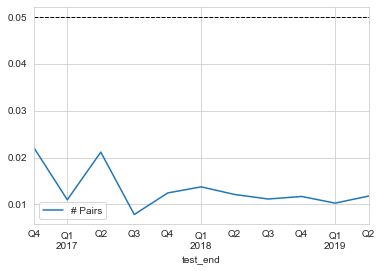

In [25]:
ax = test_results.groupby('test_end').coint.mean().to_frame('# Pairs').plot()
ax.axhline(.05, lw=1, ls='--', c='k');

### Select Candidate Pairs

In [26]:
def select_candidate_pairs(data):
    candidates = data[data.joh_sig | data.eg_sig]
    candidates['y'] = candidates.apply(lambda x: x.s1 if x.s1_dep else x.s2, axis=1)
    candidates['x'] = candidates.apply(lambda x: x.s2 if x.s1_dep else x.s1, axis=1)
    return candidates.drop(['s1_dep', 's1', 's2'], axis=1)

In [27]:
candidates = select_candidate_pairs(test_results)

In [28]:
candidates.to_hdf('backtest.h5', 'candidates')

In [29]:
candidates = pd.read_hdf('backtest.h5', 'candidates')
candidates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33661 entries, 7 to 23906
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   test_end  33661 non-null  datetime64[ns]
 1   w1        33661 non-null  float64       
 2   w2        33661 non-null  float64       
 3   joh_sig   33661 non-null  bool          
 4   eg        33661 non-null  float64       
 5   eg_sig    33661 non-null  bool          
 6   coint     33661 non-null  bool          
 7   y         33661 non-null  object        
 8   x         33661 non-null  object        
dtypes: bool(3), datetime64[ns](1), float64(3), object(2)
memory usage: 1.9+ MB


#### # Candidates over Time

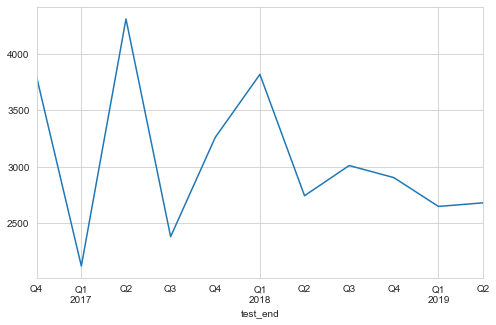

In [30]:
candidates.groupby('test_end').size().plot(figsize=(8, 5))

#### Most Common Pairs 

In [31]:
with pd.HDFStore('data.h5') as store:
    print(store.info())
    tickers = store['tickers']

<class 'pandas.io.pytables.HDFStore'>
File path: data.h5
/etfs/close              frame        (shape->[2516,139])
/stocks/close            frame        (shape->[2516,172])
/tickers                 series       (shape->[1])       


In [32]:
with pd.HDFStore('backtest.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: backtest.h5
/candidates                    frame        (shape->[33661,9])  
/cointegration_test            frame        (shape->[262988,11])


In [33]:
counter = Counter()
for s1, s2 in zip(candidates[candidates.joh_sig & candidates.eg_sig].y, 
                  candidates[candidates.joh_sig & candidates.eg_sig].x):
    if s1 > s2:
        counter[(s2, s1)] += 1
    else: 
        counter[(s1, s2)] += 1

In [34]:
most_common_pairs = pd.DataFrame(counter.most_common(10))
most_common_pairs = pd.DataFrame(most_common_pairs[0].values.tolist(), columns=['s1', 's2'])
most_common_pairs

,s1,s2
0,T.US,VOX.US
1,FXF.US,MDLZ.US
2,FXF.US,NOV.US
3,FXF.US,RIG.US
4,AMJ.US,MDLZ.US
5,DIG.US,MDLZ.US
6,DJP.US,MDLZ.US
7,ERX.US,MDLZ.US
8,FXN.US,MDLZ.US
9,IYE.US,MDLZ.US


In [59]:
with pd.HDFStore('backtest.h5') as store:
    prices = store['prices'].close.unstack('ticker').ffill(limit=5)
    tickers = store['tickers'].to_dict()

In [60]:
cnt = pd.Series(counter).reset_index()
cnt.columns = ['s1', 's2', 'n']
cnt['name1'] = cnt.s1.map(tickers)
cnt['name2'] = cnt.s2.map(tickers)
cnt.nlargest(10, columns='n')

,s1,s2,n,name1,name2
1352,T.US,VOX.US,6,AT&T,VANGUARD COMMUNICATION SERVICES ETF
384,FXF.US,MDLZ.US,5,INVESCO CURRENCYSHARES SWISS FRANC TRUST,MONDELEZ INT
388,FXF.US,NOV.US,5,INVESCO CURRENCYSHARES SWISS FRANC TRUST,NATIONAL OILWELL VARCO
391,FXF.US,RIG.US,5,INVESCO CURRENCYSHARES SWISS FRANC TRUST,TRANSOCEAN
532,AMJ.US,MDLZ.US,5,JPMORGAN ALERIAN MLP INDEX ETN,MONDELEZ INT
547,DIG.US,MDLZ.US,5,PROSHARES ULTRA OIL & GAS,MONDELEZ INT
549,DJP.US,MDLZ.US,5,IPATH BLOOMBERG COMMODITY INDEX TR ETN,MONDELEZ INT
571,ERX.US,MDLZ.US,5,DIREXION DAILY ENERGY BULL 2X SHARES,MONDELEZ INT
630,FXN.US,MDLZ.US,5,FIRST TRUST ENERGY ALPHADEX FUND,MONDELEZ INT
644,IYE.US,MDLZ.US,5,ISHARES US ENERGY ETF,MONDELEZ INT


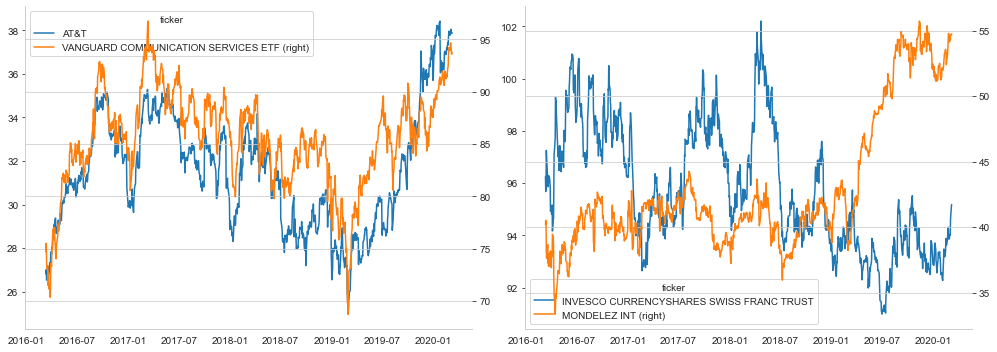

In [63]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
for i in [0, 1]:
    s1, s2 = most_common_pairs.at[i, 's1'], most_common_pairs.at[i, 's2']
    prices.loc[:, [s1, s2]].rename(columns=tickers).plot(secondary_y=tickers[s2],
                                                         ax=axes[i],
                                                         rot=0)
    axes[i].grid(False)
    axes[i].set_xlabel('')

sns.despine()
fig.tight_layout()

## Get Entry and Exit Dates 

### Smooth prices using Kalman filter

In [64]:
def KFSmoother(prices):
    """Estimate rolling mean"""
    
    kf = KalmanFilter(transition_matrices=np.eye(1),
                      observation_matrices=np.eye(1),
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=.05)

    state_means, _ = kf.filter(prices.values)
    return pd.Series(state_means.flatten(),
                     index=prices.index)

In [65]:
smoothed_prices = prices.apply(KFSmoother)
smoothed_prices.to_hdf('tmp.h5', 'smoothed')

In [66]:
smoothed_prices = pd.read_hdf('tmp.h5', 'smoothed')

### Compute rolling hedge ratio using Kalman Filter

In [67]:
def KFHedgeRatio(x, y):
    """Estimate Hedge Ratio"""
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                      initial_state_mean=[0, 0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    state_means, _ = kf.filter(y.values)
    return -state_means

### Estimate mean reversion half life

In [68]:
def estimate_half_life(spread):
    X = spread.shift().iloc[1:].to_frame().assign(const=1)
    y = spread.diff().iloc[1:]
    beta = (np.linalg.inv(X.T @ X) @ X.T @ y).iloc[0]
    halflife = int(round(-np.log(2) / beta, 0))
    return max(halflife, 1)

### Compute Spread & Bollinger Bands

In [69]:
def get_spread(candidates, prices):
    pairs = []
    half_lives = []

    periods = pd.DatetimeIndex(sorted(candidates.test_end.unique()))
    start = time()
    for p, test_end in enumerate(periods, 1):
        start_iteration = time()

        period_candidates = candidates.loc[candidates.test_end == test_end, ['y', 'x']]
        trading_start = test_end + pd.DateOffset(days=1)
        t = trading_start - pd.DateOffset(years=2)
        T = trading_start + pd.DateOffset(months=6) - pd.DateOffset(days=1)
        max_window = len(prices.loc[t: test_end].index)
        print(test_end.date(), len(period_candidates))
        for i, (y, x) in enumerate(zip(period_candidates.y, period_candidates.x), 1):
            if i % 1000 == 0:
                msg = f'{i:5.0f} | {time() - start_iteration:7.1f} | {time() - start:10.1f}'
                print(msg)
            pair = prices.loc[t: T, [y, x]]
            pair['hedge_ratio'] = KFHedgeRatio(y=KFSmoother(prices.loc[t: T, y]),
                                               x=KFSmoother(prices.loc[t: T, x]))[:, 0]
            pair['spread'] = pair[y].add(pair[x].mul(pair.hedge_ratio))
            half_life = estimate_half_life(pair.spread.loc[t: test_end])                

            spread = pair.spread.rolling(window=min(2 * half_life, max_window))
            pair['z_score'] = pair.spread.sub(spread.mean()).div(spread.std())
            pairs.append(pair.loc[trading_start: T].assign(s1=y, s2=x, period=p, pair=i).drop([x, y], axis=1))

            half_lives.append([test_end, y, x, half_life])
    return pairs, half_lives

In [70]:
candidates = pd.read_hdf('backtest.h5', 'candidates')
candidates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33661 entries, 7 to 23906
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   test_end  33661 non-null  datetime64[ns]
 1   w1        33661 non-null  float64       
 2   w2        33661 non-null  float64       
 3   joh_sig   33661 non-null  bool          
 4   eg        33661 non-null  float64       
 5   eg_sig    33661 non-null  bool          
 6   coint     33661 non-null  bool          
 7   y         33661 non-null  object        
 8   x         33661 non-null  object        
dtypes: bool(3), datetime64[ns](1), float64(3), object(2)
memory usage: 1.9+ MB


In [71]:
pairs, half_lives = get_spread(candidates, smoothed_prices)

2016-12-31 3793
 1000 |   180.5 |      180.5
 2000 |   360.7 |      360.7
 3000 |   536.6 |      536.6
2017-03-31 2118
 1000 |   206.2 |      883.1
 2000 |   415.7 |     1092.6
2017-06-30 4311
 1000 |   244.6 |     1363.1
 2000 |   486.8 |     1605.3
 3000 |   750.6 |     1869.1
 4000 |   989.5 |     2108.0
2017-09-30 2379
 1000 |   271.5 |     2481.2
 2000 |   538.0 |     2747.7
2017-12-31 3260
 1000 |   706.0 |     3554.9
 2000 |  2552.6 |     5401.5
 3000 |  2927.6 |     5776.4
2018-03-31 3819
 1000 |   354.2 |     6228.5
 2000 |   652.1 |     6526.5
 3000 |   954.5 |     6828.9
2018-06-30 2742
 1000 |   299.7 |     7372.7
 2000 |   595.4 |     7668.4
2018-09-30 3010
 1000 |   292.7 |     8182.6
 2000 |   588.5 |     8478.3
 3000 |   883.9 |     8773.7
2018-12-31 2903
 1000 |   292.5 |     9069.4
 2000 |   582.5 |     9359.4
2019-03-31 2647
 1000 |   295.1 |     9920.7
 2000 |   588.3 |    10213.9
2019-06-30 2679
 1000 |   290.2 |    10693.5
 2000 |   585.2 |    10988.6


### Collect Results

#### Half Lives

In [72]:
hl = pd.DataFrame(half_lives, columns=['test_end', 's1', 's2', 'half_life'])
hl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33661 entries, 0 to 33660
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   test_end   33661 non-null  datetime64[ns]
 1   s1         33661 non-null  object        
 2   s2         33661 non-null  object        
 3   half_life  33661 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.0+ MB


In [73]:
hl.half_life.describe()

count    33661.000000
mean        25.199519
std         10.223437
min          1.000000
25%         20.000000
50%         24.000000
75%         28.000000
max       1057.000000
Name: half_life, dtype: float64

In [74]:
hl.to_hdf('backtest.h5', 'half_lives')

#### Pair Data

In [75]:
pair_data = pd.concat(pairs)
pair_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4229473 entries, 2017-01-03 to 2019-12-31
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   hedge_ratio  4229473 non-null  float64
 1   spread       4229473 non-null  float64
 2   z_score      4229473 non-null  float64
 3   s1           4229473 non-null  object 
 4   s2           4229473 non-null  object 
 5   period       4229473 non-null  int64  
 6   pair         4229473 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 258.1+ MB


In [76]:
pair_data.to_hdf('backtest.h5', 'pair_data')

In [77]:
pair_data = pd.read_hdf('backtest.h5', 'pair_data')

### Identify Long & Short Entry and Exit Dates

In [78]:
def get_trades(data):
    pair_trades = []
    for i, ((period, s1, s2), pair) in enumerate(data.groupby(['period', 's1', 's2']), 1):
        if i % 100 == 0:
            print(i)

        first3m = pair.first('3M').index
        last3m = pair.last('3M').index

        entry = pair.z_score.abs() > 2
        entry = ((entry.shift() != entry)
                 .mul(np.sign(pair.z_score))
                 .fillna(0)
                 .astype(int)
                 .sub(2))

        exit = (np.sign(pair.z_score.shift().fillna(method='bfill'))
                != np.sign(pair.z_score)).astype(int) - 1

        trades = (entry[entry != -2].append(exit[exit == 0])
                  .to_frame('side')
                  .sort_values(['date', 'side'])
                  .squeeze())
        if not isinstance(trades, pd.Series):
            continue
        try:
            trades.loc[trades < 0] += 2
        except:
            print(type(trades))
            print(trades)
            print(pair.z_score.describe())
            break

        trades = trades[trades.abs().shift() != trades.abs()]
        window = trades.loc[first3m.min():first3m.max()]
        extra = trades.loc[last3m.min():last3m.max()]
        n = len(trades)

        if window.iloc[0] == 0:
            if n > 1:
                print('shift')
                window = window.iloc[1:]
        if window.iloc[-1] != 0:
            extra_exits = extra[extra == 0].head(1)
            if extra_exits.empty:
                continue
            else:
                window = window.append(extra_exits)

        trades = pair[['s1', 's2', 'hedge_ratio', 'period', 'pair']].join(window.to_frame('side'), how='right')
        trades.loc[trades.side == 0, 'hedge_ratio'] = np.nan
        trades.hedge_ratio = trades.hedge_ratio.ffill()
        pair_trades.append(trades)
    return pair_trades

In [79]:
pair_trades = get_trades(pair_data)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [80]:
pair_trade_data = pd.concat(pair_trades)
pair_trade_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134450 entries, 2017-01-03 to 2019-10-04
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   s1           134450 non-null  object 
 1   s2           134450 non-null  object 
 2   hedge_ratio  134450 non-null  float64
 3   period       134450 non-null  int64  
 4   pair         134450 non-null  int64  
 5   side         134450 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 7.2+ MB


In [81]:
pair_trade_data.head()

,s1,s2,hedge_ratio,period,pair,side
date,,,,,,
2017-01-03,AA.US,ACWI.US,-0.533861,1,16,-1
2017-01-12,AA.US,ACWI.US,-0.533861,1,16,0
2017-01-03,AA.US,ACWX.US,-0.799916,1,54,-1
2017-01-12,AA.US,ACWX.US,-0.799916,1,54,0
2017-01-03,AA.US,DEM.US,-0.896395,1,376,-1


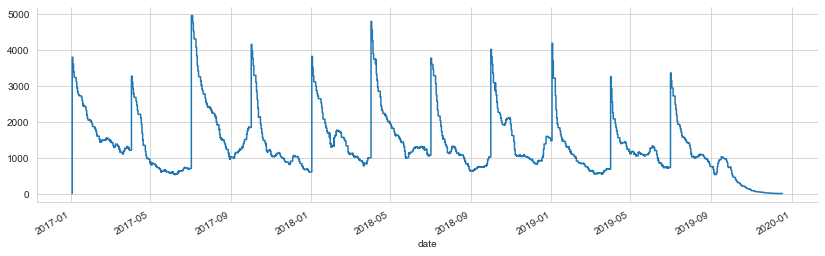

In [84]:
trades = pair_trade_data['side'].copy()
trades.loc[trades != 0] = 1
trades.loc[trades == 0] = -1
trades.sort_index().cumsum().plot(figsize=(14, 4))
sns.despine()

In [83]:
pair_trade_data.to_hdf('backtest.h5', 'pair_trades')